In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ventas = pd.read_excel("../datasets/cleaned2/ventas.xlsx")
clientes = pd.read_excel("../datasets/cleaned2/clientes.xlsx")
materiales = pd.read_excel("../datasets/cleaned2/materiales.xlsx")

In [3]:
clientes

,id_cliente,nombre_cliente,categoría
0,906600,TRANSPORTISTAS NUTRICIONALES,desconocido
1,909009,ABBOTT LABORATORIES DE MEXICO,desconocido
2,400043,ZAVALA SALAZAR LAURA ELENA,persona natural
3,400047,ORTIZ BERNAL ANA DANIELA,persona natural
4,400050,AGUILAR REYES ALEJANDRO,persona natural
...,...,...,...
333,801850,HOSPITAL GENERAL DE MEXICO,ISSSTE
334,801950,INSTITUTO NACIONAL DE ENFERME,ISSSTE
335,802050,INSTITUTO NACIONAL DE CIENCIAS,ISSSTE
336,903341,SERVICIOS Y DISTRIBUCION ALTA ESPECIALIDAD HOS...,ISSSTE


# **Estrategias analiticas Dattec**

Este notebook contiene **todas las estrategias** propuestas para el caso de estudio de Dattec SAS.
Cada sección tiene: objetivo de negocio, explicación breve y el bloque de código listo para integrar al ETL.

Datos esperados (ya presentes en el entorno): `ventas`, `clientes`, `materiales`.
- `ventas`: columnas mínimas `periodo` (datetime64[ns]), `id_cliente`, `id_material`, `unidades`, `valores`, `type`.
- `clientes`: `id_cliente`, `nombre_cliente`, `categoría`.
- `materiales`: `id_material`, `nombre_material`, `categoría`.


## 1) Segmentación Pareto (80/20) por clientes

Objetivo: Identificar el ~20% de clientes que concentran ~80% del valor; definir planes de fidelización y SLAs diferenciados.

In [4]:
# Segmentación Pareto por cliente
df_cli_val = ventas.groupby("id_cliente", as_index=False)["valores"].sum().sort_values("valores", ascending=False)
df_cli_val["participacion"] = df_cli_val["valores"] / df_cli_val["valores"].sum()
df_cli_val["acumulado"] = df_cli_val["participacion"].cumsum()
clientes_pareto = df_cli_val[df_cli_val["acumulado"] <= 0.80]["id_cliente"]
ventas["segmento_cliente_pareto"] = np.where(ventas["id_cliente"].isin(clientes_pareto), "Top80", "Resto")
print(f"Clientes Pareto: {len(clientes_pareto)}")

Clientes Pareto: 9


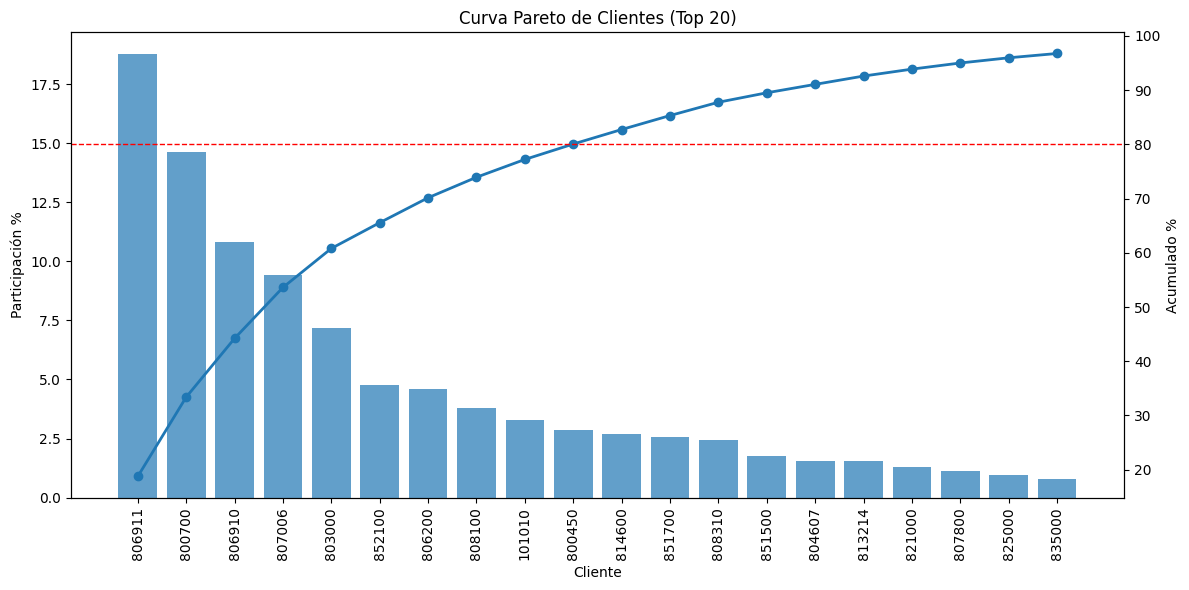

In [5]:
# --- Parámetros ---
top_n = 20  # Número de clientes a mostrar en el gráfico

# --- Preparar datos para gráfico ---
df_plot = df_cli_val.head(top_n).copy()
df_plot["acumulado_pct"] = df_plot["acumulado"] * 100
df_plot["participacion_pct"] = df_plot["participacion"] * 100

# --- Crear figura ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras (participación individual)
ax1.bar(df_plot["id_cliente"].astype(str), df_plot["participacion_pct"], label="Participación % (cliente)", alpha=0.7)
ax1.set_xlabel("Cliente")
ax1.set_ylabel("Participación %", color="black")
ax1.tick_params(axis='x', rotation=90)

# Curva acumulada
ax2 = ax1.twinx()
ax2.plot(df_plot["id_cliente"].astype(str), df_plot["acumulado_pct"], marker='o', label="Acumulado %", linewidth=2)
ax2.set_ylabel("Acumulado %", color="black")
ax2.axhline(80, color="red", linestyle="--", linewidth=1)

# Títulos y leyenda
plt.title("Curva Pareto de Clientes (Top {})".format(top_n))
fig.tight_layout()
plt.show()


## 2) Segmentación Pareto por materiales

Objetivo: Optimizar el portafolio identificando los materiales que mueven la mayor parte del negocio.

In [6]:
# Pareto por material
df_mat_val = ventas.groupby("id_material", as_index=False)["valores"].sum().sort_values("valores", ascending=False)
df_mat_val["participacion"] = df_mat_val["valores"] / df_mat_val["valores"].sum()
df_mat_val["acumulado"] = df_mat_val["participacion"].cumsum()
materiales_pareto = df_mat_val[df_mat_val["acumulado"] <= 0.80]["id_material"]
ventas["segmento_material_pareto"] = np.where(ventas["id_material"].isin(materiales_pareto), "Top80", "Resto")
print(f"Materiales Pareto: {len(materiales_pareto)}")

Materiales Pareto: 95


C:\Users\gabri\AppData\Local\Temp\ipykernel_13392\177306123.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


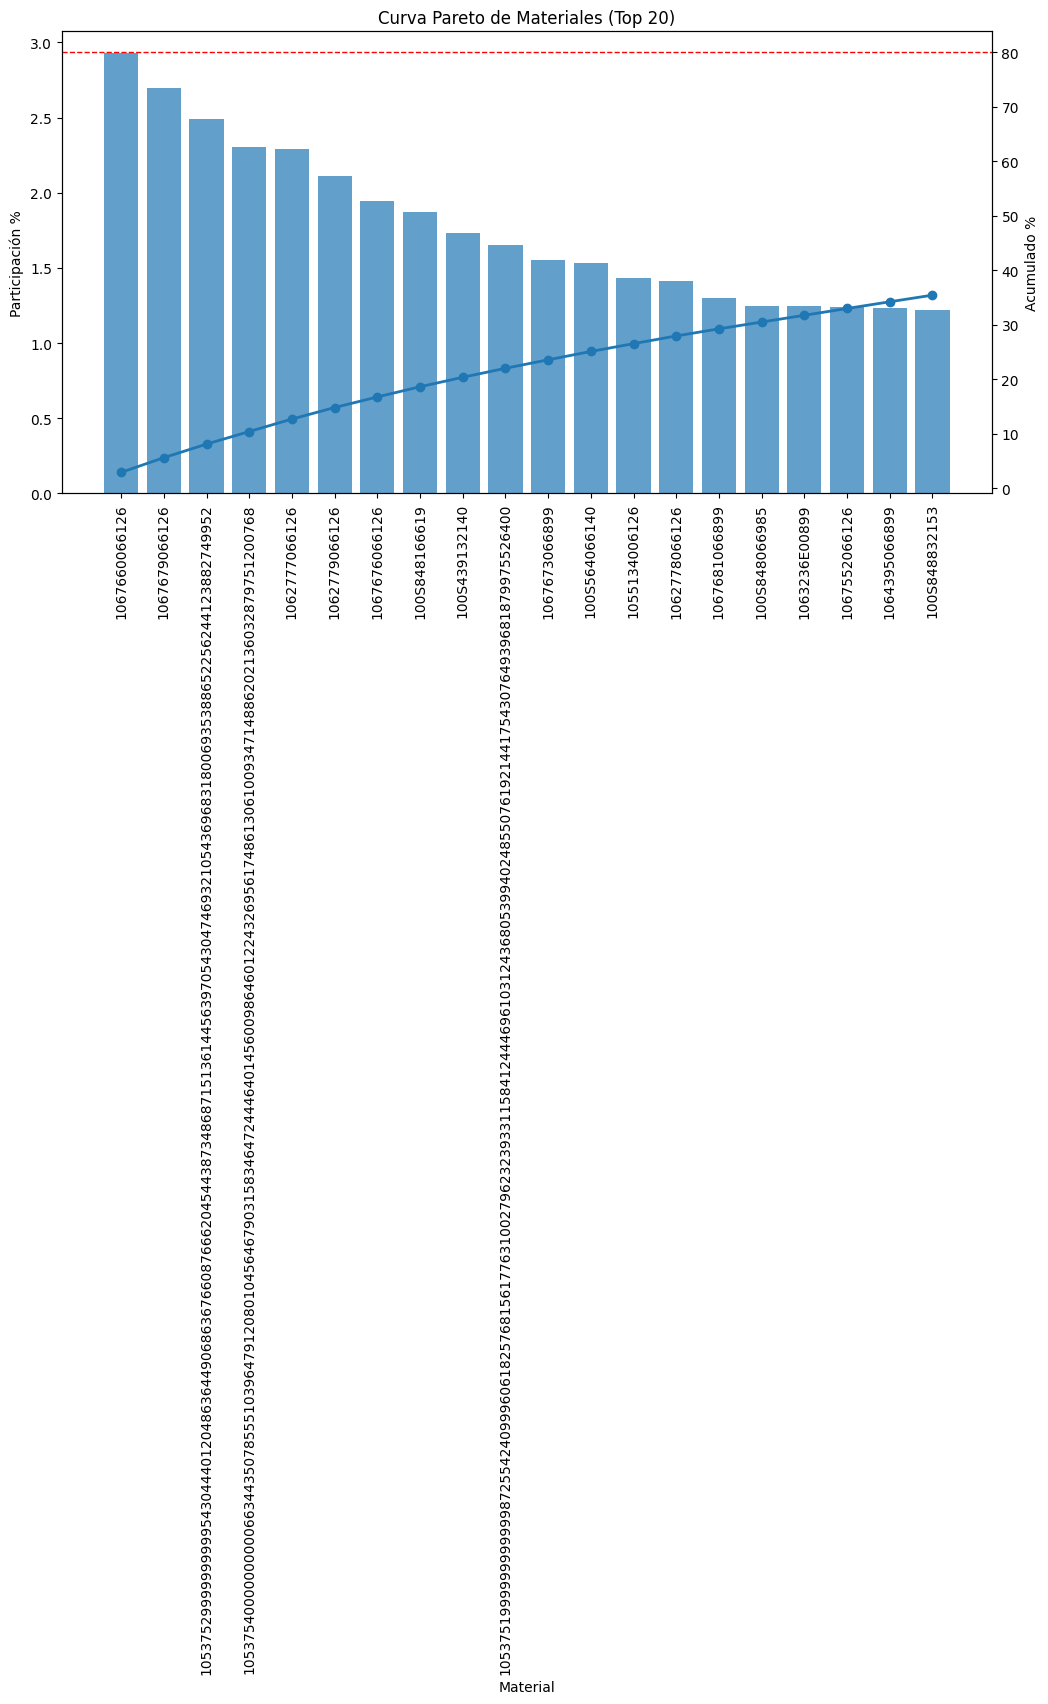

In [7]:
# --- Parámetros ---
top_n = 20  # Número de materiales a mostrar

# --- Preparar datos para gráfico ---
df_plot_mat = df_mat_val.head(top_n).copy()
df_plot_mat["acumulado_pct"] = df_plot_mat["acumulado"] * 100
df_plot_mat["participacion_pct"] = df_plot_mat["participacion"] * 100

# --- Crear figura ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras
ax1.bar(df_plot_mat["id_material"].astype(str), df_plot_mat["participacion_pct"], label="Participación % (material)", alpha=0.7)
ax1.set_xlabel("Material")
ax1.set_ylabel("Participación %", color="black")
ax1.tick_params(axis='x', rotation=90)

# Curva acumulada
ax2 = ax1.twinx()
ax2.plot(df_plot_mat["id_material"].astype(str), df_plot_mat["acumulado_pct"], marker='o', label="Acumulado %", linewidth=2)
ax2.set_ylabel("Acumulado %", color="black")
ax2.axhline(80, color="red", linestyle="--", linewidth=1)

# Títulos y leyenda
plt.title("Curva Pareto de Materiales (Top {})".format(top_n))
fig.tight_layout()
plt.show()


## 3) Crecimiento de clientes (YoY / MoM)

Objetivo: Detectar clientes con tracción positiva para priorizar acciones de up-sell o expansión.

In [37]:
# Crecimiento anual y mensual por cliente
ventas["anio"] = ventas["periodo"].dt.year
ventas["mes"]  = ventas["periodo"].dt.to_period("M")
cli_year = ventas.groupby(["id_cliente", "anio"], as_index=False)["valores"].sum()
cli_year["crecimiento_yoy"] = cli_year.groupby("id_cliente")["valores"].pct_change()
clientes_en_crecimiento = cli_year[cli_year["crecimiento_yoy"] > 0.20]
clientes_en_caida      = cli_year[cli_year["crecimiento_yoy"] < 0.20]
print("Clientes en crecimiento (>20% YoY):", clientes_en_crecimiento["id_cliente"].nunique())

Clientes en crecimiento (>20% YoY): 28


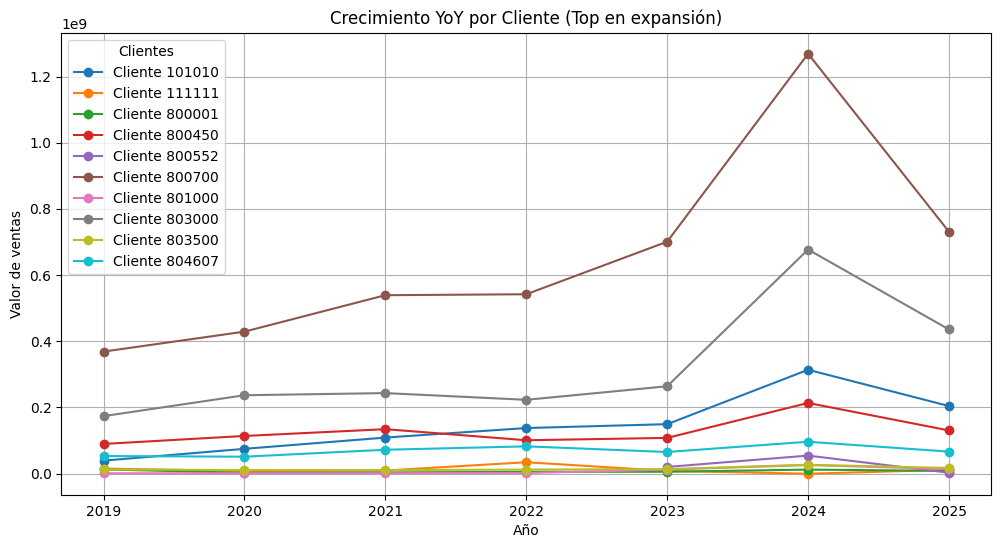

In [38]:
# --- Seleccionar solo clientes con crecimiento positivo importante ---
top_growth_clients = clientes_en_crecimiento["id_cliente"].unique()[:10]  # Top 10 para visualización

plt.figure(figsize=(12,6))

for cli in top_growth_clients:
    df_cli = cli_year[cli_year["id_cliente"] == cli].sort_values("anio")
    plt.plot(df_cli["anio"], df_cli["valores"], marker='o', label=f"Cliente {cli}")

plt.title("Crecimiento YoY por Cliente (Top en expansión)")
plt.xlabel("Año")
plt.ylabel("Valor de ventas")
plt.legend(title="Clientes")
plt.grid(True)
plt.show()


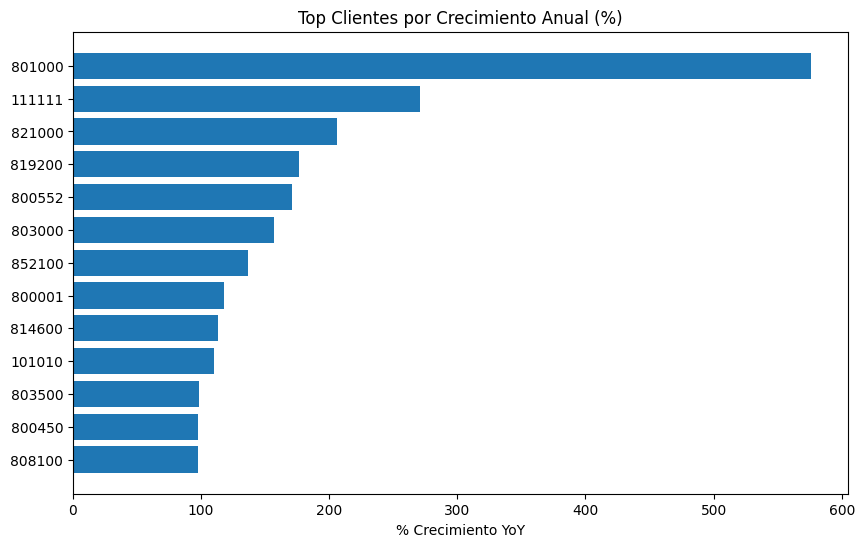

In [39]:
# Obtener solo el último año con crecimiento calculado
df_growth_latest = cli_year.dropna(subset=["crecimiento_yoy"]).sort_values("crecimiento_yoy", ascending=False)

# Top 15 clientes con mayor crecimiento
df_top_growth = df_growth_latest.head(15)

plt.figure(figsize=(10,6))
plt.barh(df_top_growth["id_cliente"].astype(str), df_top_growth["crecimiento_yoy"] * 100)
plt.xlabel("% Crecimiento YoY")
plt.title("Top Clientes por Crecimiento Anual (%)")
plt.gca().invert_yaxis()  # Para que el mayor quede arriba
plt.show()


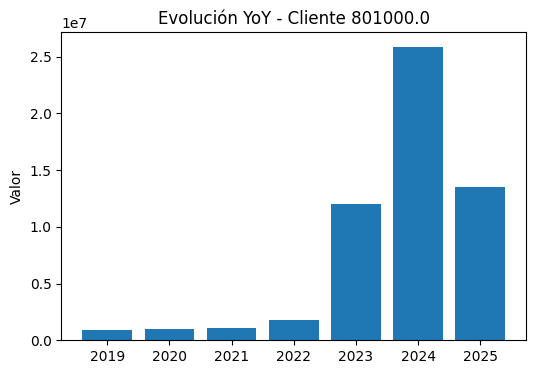

In [45]:
cliente_demo = df_growth_latest.iloc[0]["id_cliente"]  # Cliente con mayor crecimiento
df_demo = cli_year[cli_year["id_cliente"] == cliente_demo].sort_values("anio")

plt.figure(figsize=(6,4))
plt.bar(df_demo["anio"].astype(str), df_demo["valores"])
plt.title(f"Evolución YoY - Cliente {cliente_demo}")
plt.ylabel("Valor")
plt.show()


## 4) Detección de churn / riesgo

Objetivo: Identificar cuentas en descenso o inactivas para activar planes de recuperación.

In [46]:
# Detección de riesgo y clientes inactivos
clientes_riesgo_yoy = cli_year[cli_year["crecimiento_yoy"] < 0.20]["id_cliente"].unique()
ultima_fecha = ventas["periodo"].max()
recencia_cli = ventas.groupby("id_cliente")["periodo"].max().reset_index()
recencia_cli["dias_desde_ultima_compra"] = (ultima_fecha - recencia_cli["periodo"]).dt.days
clientes_inactivos_90d = recencia_cli[recencia_cli["dias_desde_ultima_compra"] > 90]["id_cliente"].unique()
ventas["flag_churn_riesgo"] = np.where(ventas["id_cliente"].isin(set(clientes_riesgo_yoy).union(set(clientes_inactivos_90d))), 1, 0)
print("Clientes en riesgo (YoY o +90d inactivos):", len(set(clientes_riesgo_yoy).union(set(clientes_inactivos_90d))))

Clientes en riesgo (YoY o +90d inactivos): 32


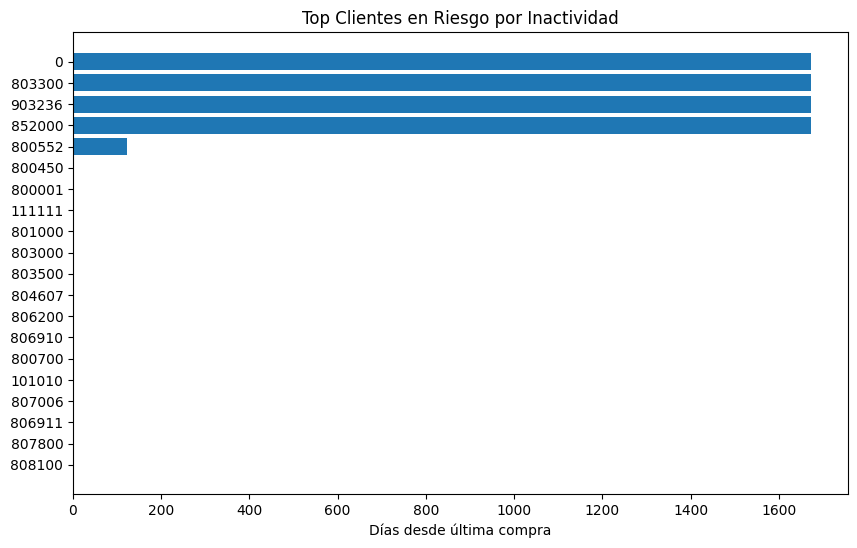

In [47]:
# Filtrar dataframe de recencia solo para los clientes marcados en riesgo
df_riesgo = recencia_cli[recencia_cli["id_cliente"].isin(set(clientes_riesgo_yoy).union(set(clientes_inactivos_90d)))]

# Ordenar por cliente más inactivo
df_riesgo_sorted = df_riesgo.sort_values("dias_desde_ultima_compra", ascending=False).head(20)  # Top 20 más críticos

plt.figure(figsize=(10,6))
plt.barh(df_riesgo_sorted["id_cliente"].astype(str), df_riesgo_sorted["dias_desde_ultima_compra"])
plt.xlabel("Días desde última compra")
plt.title("Top Clientes en Riesgo por Inactividad")
plt.gca().invert_yaxis()
plt.show()


## 5) Share of Wallet

Objetivo: Medir dependencia de la empresa en clientes clave (concentración).

In [14]:
len(ventas['id_cliente'].unique())

33

In [15]:
# Share of Wallet por cliente
df_total = ventas["valores"].sum()
df_sow   = ventas.groupby("id_cliente", as_index=False)["valores"].sum().rename(columns={"valores": "val_total_cli"})
df_sow["share_of_wallet"] = df_sow["val_total_cli"] / df_total
df_sow = df_sow.merge(clientes[["id_cliente", "nombre_cliente"]], on="id_cliente", how="left")
df_sow = df_sow.sort_values("share_of_wallet", ascending=False)
df_sow

,id_cliente,val_total_cli,share_of_wallet,nombre_cliente
14,806911,5.872235e+09,1.875738e-01,NUEVA WAL MART DE MEXICO
6,800700,4.579391e+09,1.462771e-01,FARMACIA GUADALAJARA
13,806910,3.390473e+09,1.083001e-01,NUEVA WAL MART DE MEXICO
15,807006,2.943711e+09,9.402946e-02,SERVICIOS EN PUERTOS Y TERMINA
8,803000,2.253306e+09,7.197618e-02,NADRO
31,852100,1.486376e+09,4.747856e-02,DISTRIBUCIONES NUTRICIONALES
12,806200,1.439909e+09,4.599427e-02,COSTCO DE MEXICO
17,808100,1.184097e+09,3.782301e-02,FARMACIAS BENAVIDES
1,101010,1.027744e+09,3.282871e-02,NaN
4,800450,8.901575e+08,2.843384e-02,PHARMA PLUS


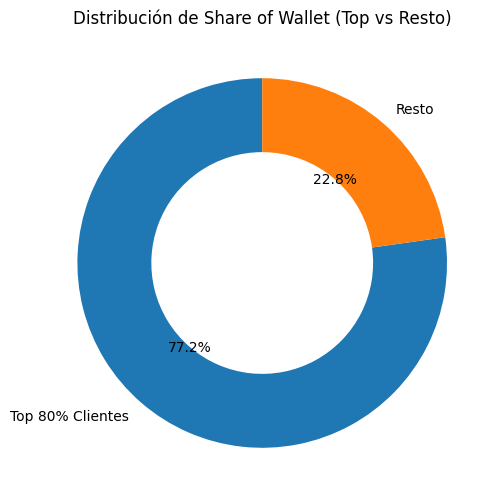

In [16]:
top80_total = df_sow[df_sow["share_of_wallet"].cumsum() <= 0.80]["val_total_cli"].sum()
resto_total = df_total - top80_total

plt.figure(figsize=(6,6))
plt.pie([top80_total, resto_total], labels=["Top 80% Clientes", "Resto"], autopct="%1.1f%%", startangle=90, wedgeprops=dict(width=0.4))
plt.title("Distribución de Share of Wallet (Top vs Resto)")
plt.show()


## 6) Mix por categoría de producto

Objetivo: Entender mezcla por familias para ajustar precios/portafolio y campañas.

In [17]:
# Mix por categoria
ventas_mat = ventas.merge(materiales[["id_material", "nombre_material", "categoría"]], on="id_material", how="left")
mix_categoria = ventas_mat.groupby("categoría", as_index=False)[["valores","unidades"]].sum()
mix_categoria["pct_part_valor"] = mix_categoria["valores"] / mix_categoria["valores"].sum()
mix_categoria["pct_part_unid"]  = mix_categoria["unidades"] / mix_categoria["unidades"].sum()
mix_categoria.sort_values("pct_part_valor", ascending=False)

,categoría,valores,unidades,pct_part_valor,pct_part_unid
0,ADULT NUTRITIONALS,8.955074e+09,1.441661e+08,0.608837,0.68081
2,PEDIATRIC NUTRITION,5.212054e+09,3.983993e+07,0.354357,0.18814
1,HYDRATION,5.413609e+08,2.775079e+07,0.036806,0.13105


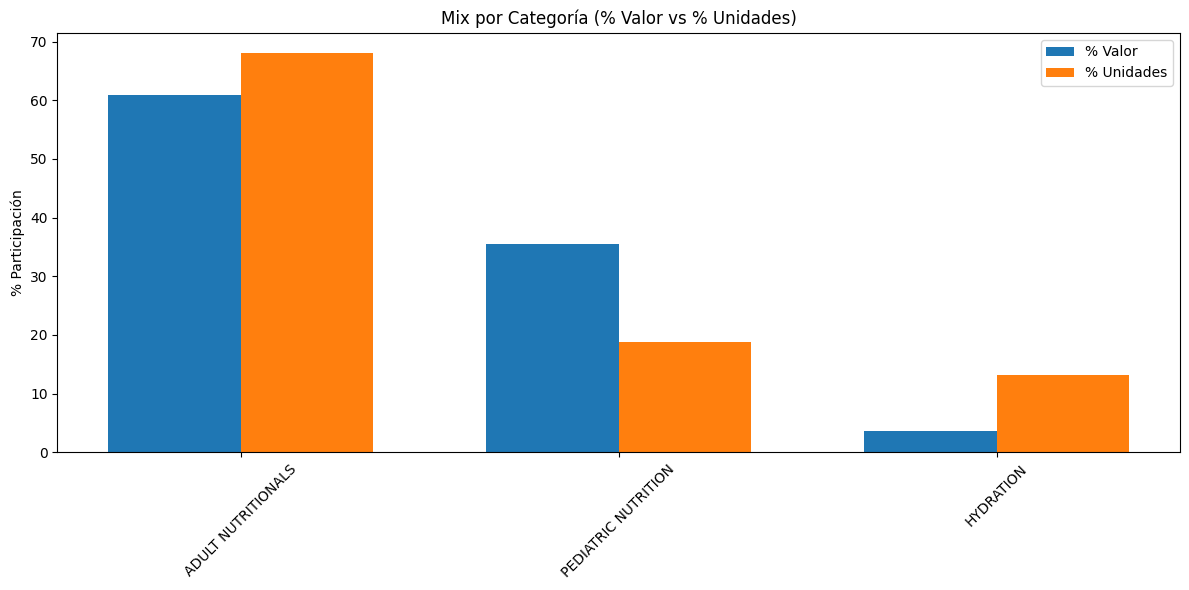

In [18]:
# Ordenar por participación en valor
df_mix = mix_categoria.sort_values("pct_part_valor", ascending=False)

x = np.arange(len(df_mix["categoría"]))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, df_mix["pct_part_valor"] * 100, width, label="% Valor")
plt.bar(x + width/2, df_mix["pct_part_unid"] * 100, width, label="% Unidades")

plt.xticks(x, df_mix["categoría"], rotation=45)
plt.ylabel("% Participación")
plt.title("Mix por Categoría (% Valor vs % Unidades)")
plt.legend()
plt.tight_layout()
plt.show()


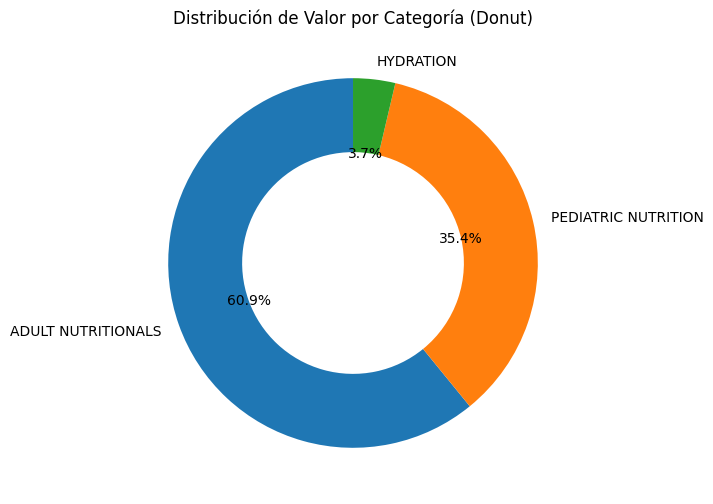

In [19]:
plt.figure(figsize=(6,6))
plt.pie(df_mix["pct_part_valor"], labels=df_mix["categoría"], autopct="%1.1f%%", startangle=90, wedgeprops=dict(width=0.4))
plt.title("Distribución de Valor por Categoría (Donut)")
plt.show()


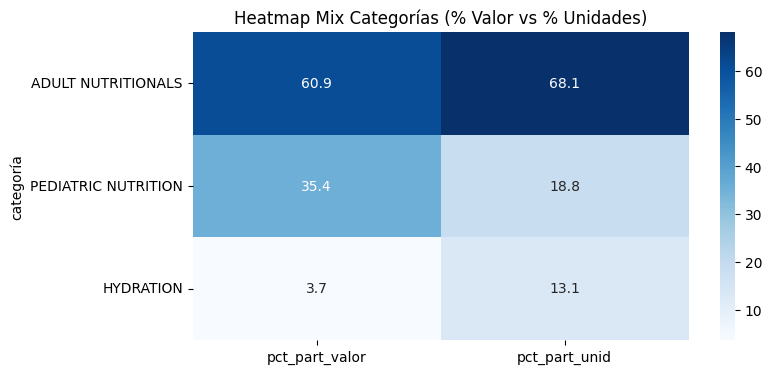

In [20]:
plt.figure(figsize=(8,4))
sns.heatmap(df_mix[["pct_part_valor","pct_part_unid"]].set_index(df_mix["categoría"]) * 100, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap Mix Categorías (% Valor vs % Unidades)")
plt.show()

## 7) Estacionalidad (mes/trimestre)

Objetivo: Planificar inventario y campañas anticipando picos y valles de demanda.

In [21]:
# Estacionalidad por mes y trimestre
ventas["trim"] = ventas["periodo"].dt.to_period("Q")
ts_mes  = ventas.groupby(ventas["periodo"].dt.to_period("M"))["valores"].sum().reset_index(name="valores")
ts_trim = ventas.groupby("trim")["valores"].sum().reset_index(name="valores")
ts_mes["mes_num"] = ts_mes["periodo"].dt.month
mes_mean = ts_mes.groupby("mes_num")["valores"].mean()
indice_estacional = (mes_mean / mes_mean.mean()).rename("indice_estacional_mes")
indice_estacional

mes_num
1     1.065882
2     1.043480
3     1.060349
4     1.075911
5     1.103013
6     1.088442
7     1.067868
8     0.934291
9     0.864671
10    0.965309
11    0.854386
12    0.876398
Name: indice_estacional_mes, dtype: float64

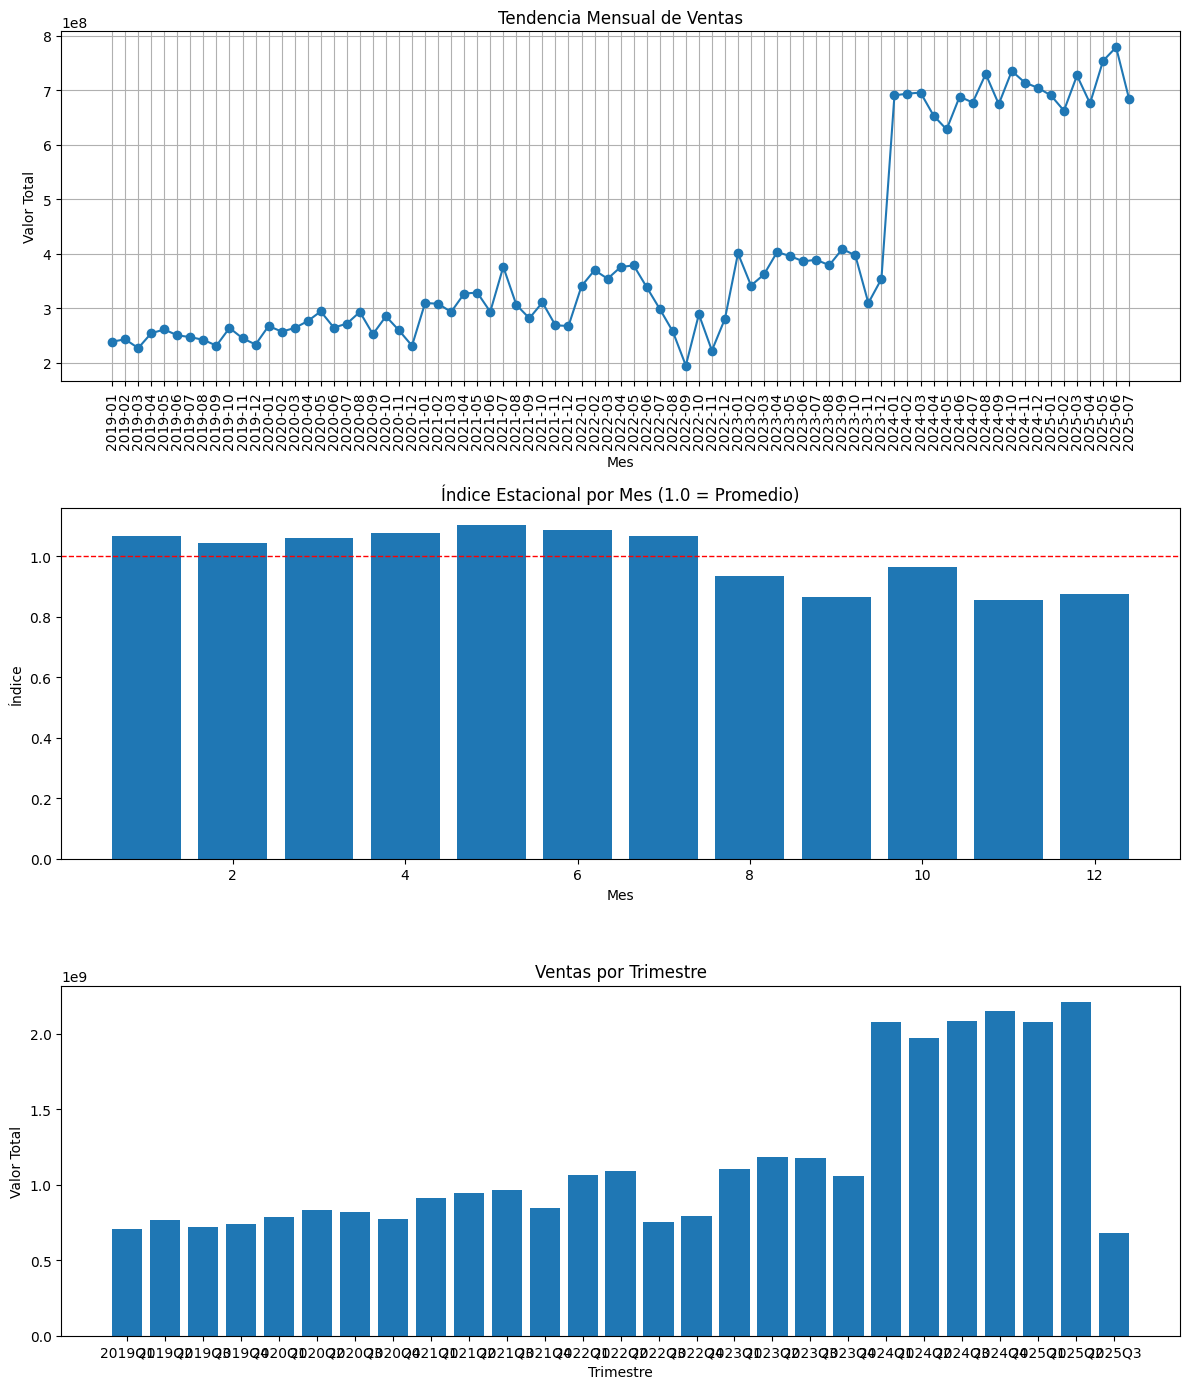

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(12,14))

# --- 1) Tendencia Mensual ---
axes[0].plot(ts_mes["periodo"].astype(str), ts_mes["valores"], marker='o')
axes[0].set_title("Tendencia Mensual de Ventas")
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Valor Total")
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True)

# --- 2) Índice Estacional ---
axes[1].bar(indice_estacional.index, indice_estacional.values)
axes[1].set_title("Índice Estacional por Mes (1.0 = Promedio)")
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Índice")
axes[1].axhline(1, color='red', linestyle='--', linewidth=1)

# --- 3) Ventas por Trimestre ---
axes[2].bar(ts_trim["trim"].astype(str), ts_trim["valores"])
axes[2].set_title("Ventas por Trimestre")
axes[2].set_xlabel("Trimestre")
axes[2].set_ylabel("Valor Total")

plt.tight_layout()
plt.show()


## 8) Forecast simple (MA + lineal)

Objetivo: Previsión rápida para compras/producción (benchmark inicial).

In [ ]:
X = np.arange(len(serie_m)).reshape(-1,1)

'''[[0],
 [1],
 [2],
 [3],
 [4]]'''

'[[0],\n [1],\n [2],\n [3],\n [4]]'

In [64]:
# Forecast: promedio móvil y tendencia lineal
serie_m = (ventas.set_index("periodo")
                .resample("MS")["valores"].sum()
                .reset_index())
window = 3
serie_m["forecast_ma"] = serie_m["valores"].rolling(window=window).mean().shift(1)
try:
    from sklearn.linear_model import LinearRegression
    import numpy as np
    X = np.arange(len(serie_m)).reshape(-1,1)
    y = serie_m["valores"].values
    lr = LinearRegression().fit(X, y)
    serie_m["forecast_lr"] = lr.predict(X)
except Exception:
    serie_m["forecast_lr"] = np.nan
serie_m

,periodo,valores,forecast_ma,forecast_lr
0,2019-01-01,2.384612e+08,NaN,1.406825e+08
1,2019-02-01,2.429077e+08,NaN,1.472363e+08
2,2019-03-01,2.266894e+08,NaN,1.537901e+08
3,2019-04-01,2.540531e+08,2.360194e+08,1.603439e+08
4,2019-05-01,2.608678e+08,2.412167e+08,1.668978e+08
...,...,...,...,...
74,2025-03-01,7.272855e+08,6.860405e+08,6.256659e+08
75,2025-04-01,6.761132e+08,6.935783e+08,6.322198e+08
76,2025-05-01,7.541977e+08,6.887026e+08,6.387736e+08
77,2025-06-01,7.791619e+08,7.191988e+08,6.453274e+08


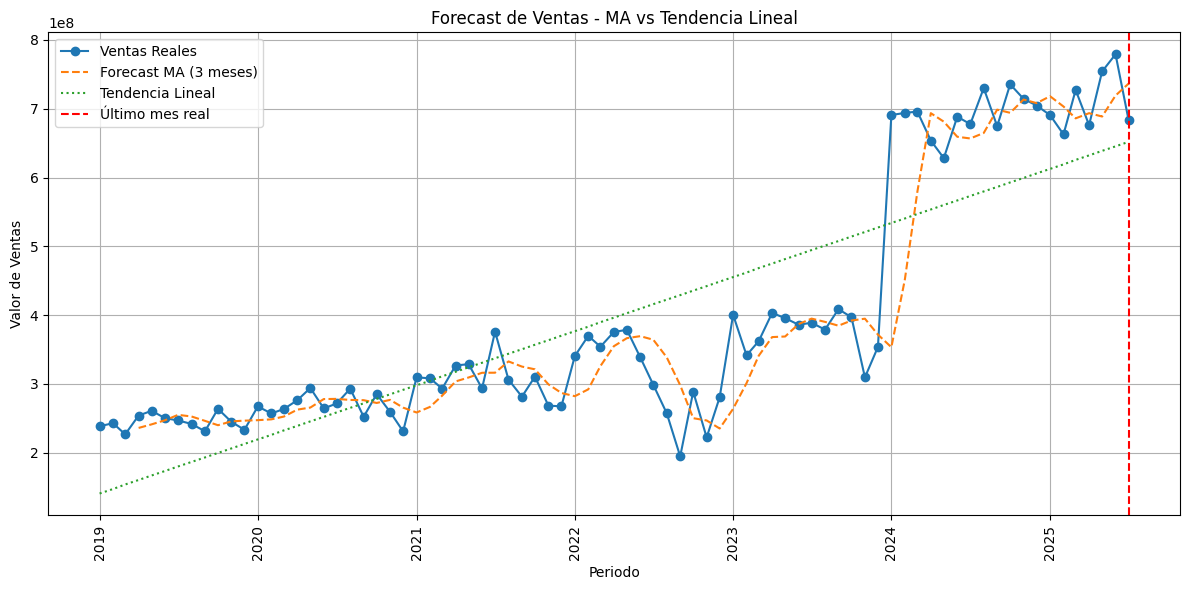

In [24]:
plt.figure(figsize=(12,6))

# Serie real
plt.plot(serie_m["periodo"], serie_m["valores"], label="Ventas Reales", marker='o')

# Forecast - Promedio móvil
plt.plot(serie_m["periodo"], serie_m["forecast_ma"], label=f"Forecast MA ({window} meses)", linestyle="--")

# Forecast - Tendencia Lineal
plt.plot(serie_m["periodo"], serie_m["forecast_lr"], label="Tendencia Lineal", linestyle=":")

# Línea vertical marcando el punto actual
plt.axvline(serie_m["periodo"].iloc[-1], color="red", linestyle="--", label="Último mes real")

plt.title("Forecast de Ventas - MA vs Tendencia Lineal")
plt.xlabel("Periodo")
plt.ylabel("Valor de Ventas")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 9) RFM (Recency, Frequency, Monetary)

Objetivo: Segmentación avanzada para acciones de marketing y scoring de clientes.

In [25]:
# RFM básico
ref_date = ventas["periodo"].max()
df_rfm = ventas.groupby("id_cliente").agg(
    ultima_compra=("periodo", "max"),
    frecuencia=("id_material", "count"),
    monetario=("valores", "sum")
).reset_index()
df_rfm["recencia_dias"] = (ref_date - df_rfm["ultima_compra"]).dt.days
df_rfm["R_score"] = pd.cut(-df_rfm["recencia_dias"], 4, labels=[1,2,3,4])
df_rfm["F_score"] = pd.cut(df_rfm["frecuencia"], 4, labels=[1,2,3,4])
df_rfm["M_score"] = pd.cut(df_rfm["monetario"], 4, labels=[1,2,3,4])
df_rfm["RFM"] = df_rfm["R_score"].astype(str) + df_rfm["F_score"].astype(str) + df_rfm["M_score"].astype(str)
df_rfm.head()

,id_cliente,ultima_compra,frecuencia,monetario,recencia_dias,R_score,F_score,M_score,RFM
0,0,2020-12-01,132,-1.758730e+03,1673,1,1,1,111
1,101010,2025-07-01,8742,1.027744e+09,0,4,4,1,441
2,111111,2025-07-01,6978,8.533236e+07,0,4,3,1,431
3,800001,2025-07-01,8654,4.959484e+07,0,4,4,1,441
4,800450,2025-07-01,11466,8.901575e+08,0,4,4,1,441


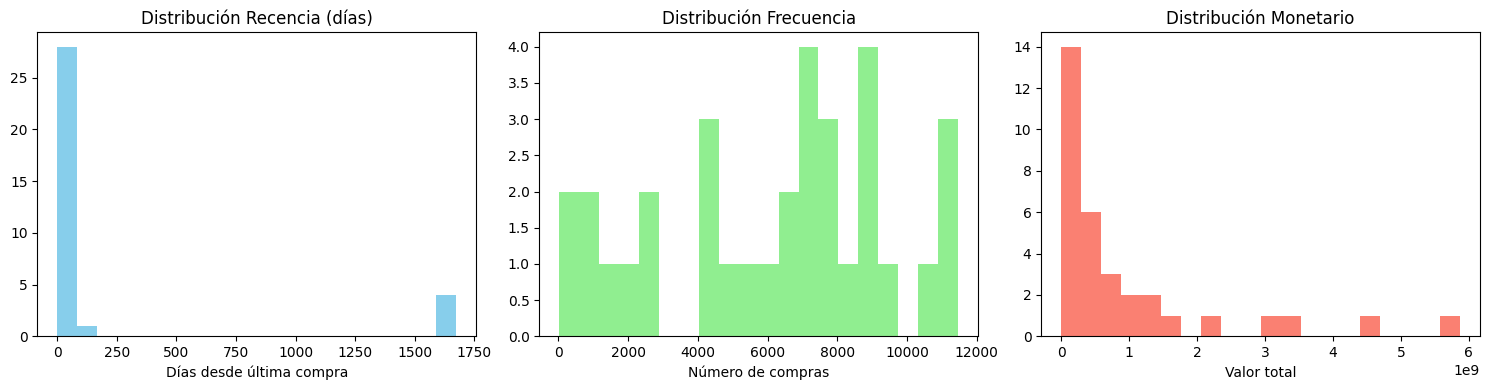

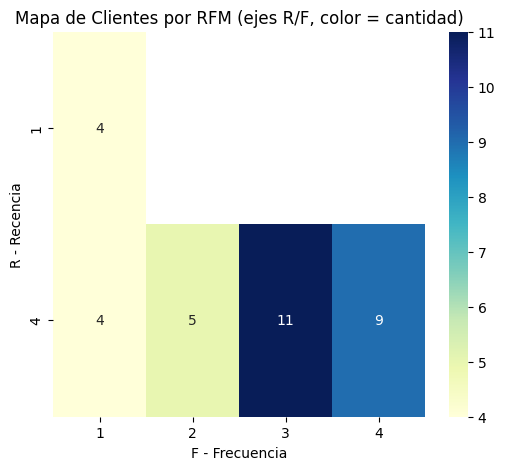

In [26]:
# --- 1) Histogramas de Recencia, Frecuencia y Monetario ---
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(df_rfm["recencia_dias"], bins=20, color="skyblue")
axes[0].set_title("Distribución Recencia (días)")
axes[0].set_xlabel("Días desde última compra")

axes[1].hist(df_rfm["frecuencia"], bins=20, color="lightgreen")
axes[1].set_title("Distribución Frecuencia")
axes[1].set_xlabel("Número de compras")

axes[2].hist(df_rfm["monetario"], bins=20, color="salmon")
axes[2].set_title("Distribución Monetario")
axes[2].set_xlabel("Valor total")

plt.tight_layout()
plt.show()

# --- 2) Heatmap de combinaciones RFM ---
df_heat = df_rfm.groupby("RFM")["id_cliente"].count().reset_index()
df_heat["R"] = df_heat["RFM"].str[0].astype(int)
df_heat["F"] = df_heat["RFM"].str[1].astype(int)
df_heat["M"] = df_heat["RFM"].str[2].astype(int)

pivot_rfm = df_heat.pivot_table(index="R", columns="F", values="id_cliente", aggfunc="sum")

plt.figure(figsize=(6,5))
sns.heatmap(pivot_rfm, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Mapa de Clientes por RFM (ejes R/F, color = cantidad)")
plt.xlabel("F - Frecuencia")
plt.ylabel("R - Recencia")
plt.show()


## 10) Margen estimado / integración de costos

Objetivo: Pasar de ventas a rentabilidad; propuesta de integración futura de costos por material.

In [62]:
# Margen estimado (placeholder) y propuesta de integración
ventas["margen_estimado"] = ventas["valores"] * 0.30
# Si hubiese df_costos por id_material, unir y calcular margen real:
# ventas = ventas.merge(costos[["id_material","costo_unit"]], on="id_material", how="left")
# ventas["margen_real"] = ventas["valores"] - (ventas["unidades"] * ventas["costo_unit"])
ventas[["margen_estimado"]]

,margen_estimado
0,1.312011e+06
1,1.423183e+06
2,1.128757e+06
3,7.347245e+05
4,2.542043e+05
...,...
201810,6.790909e+05
201811,-8.607720e+02
201812,-7.995120e+02
201813,-2.187780e+03


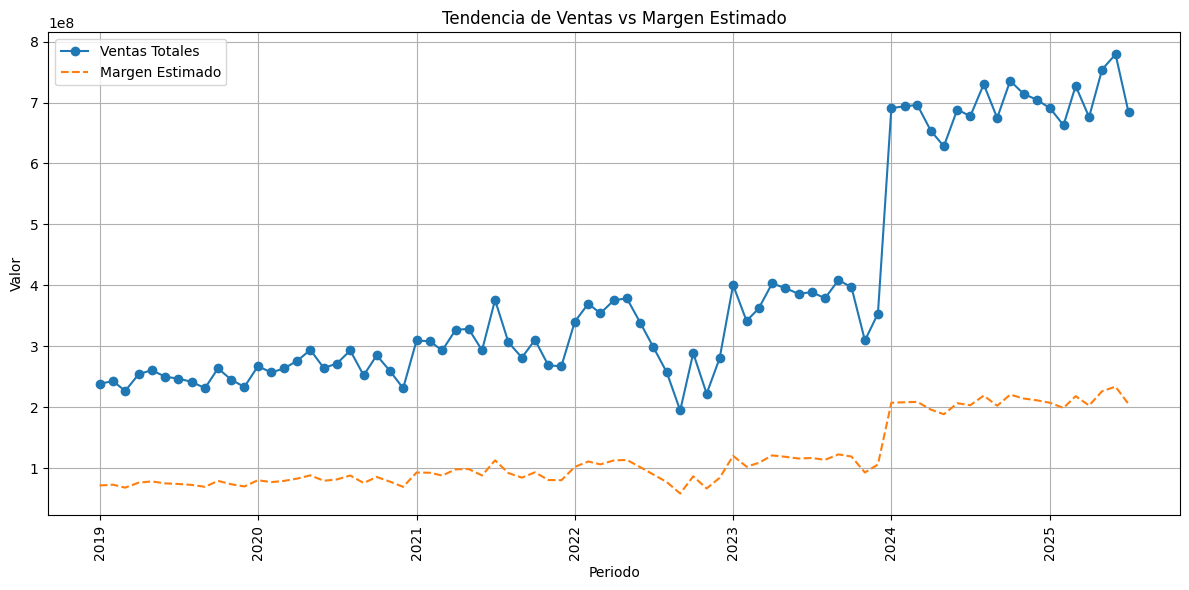

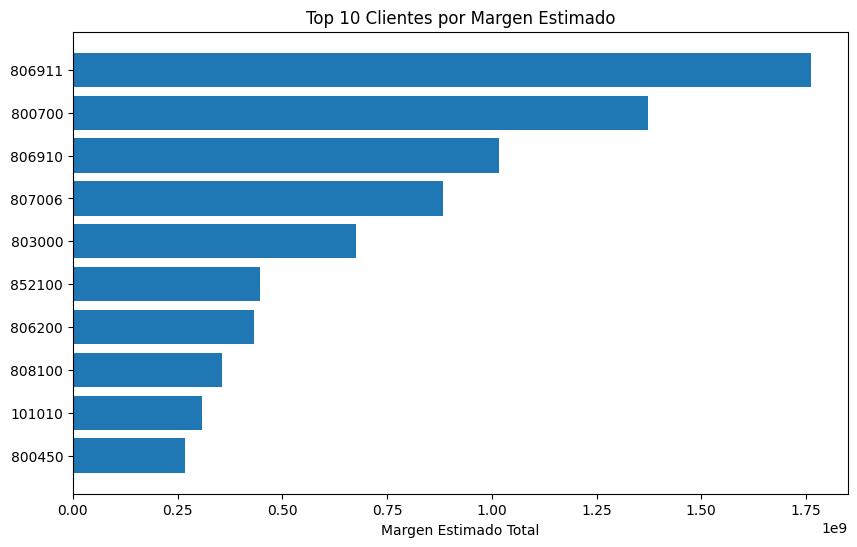

In [28]:
# 1) Tendencia de Ventas vs Margen Estimado

ventas_mes = (ventas
              .set_index("periodo")
              .resample("MS")[["valores","margen_estimado"]]
              .sum()
              .reset_index())

plt.figure(figsize=(12,6))
plt.plot(ventas_mes["periodo"], ventas_mes["valores"], label="Ventas Totales", marker='o')
plt.plot(ventas_mes["periodo"], ventas_mes["margen_estimado"], label="Margen Estimado", linestyle="--")
plt.title("Tendencia de Ventas vs Margen Estimado")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2) Top Clientes por Margen

top_cli_margin = ventas.groupby("id_cliente")["margen_estimado"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_cli_margin.index.astype(str), top_cli_margin.values)
plt.title("Top 10 Clientes por Margen Estimado")
plt.xlabel("Margen Estimado Total")
plt.gca().invert_yaxis()
plt.show()



## 11) Nuevos vs Recurrentes y Retención

Objetivo: Medir adquisición vs lealtad; calcular retención mensual.

In [29]:
# Nuevos vs Recurrentes y retencion simple
primera_compra = ventas.groupby("id_cliente", as_index=False)["periodo"].min().rename(columns={"periodo":"primer_periodo"})
ventas = ventas.merge(primera_compra, on="id_cliente", how="left")
ventas["tipo_cliente"] = np.where(ventas["periodo"] == ventas["primer_periodo"], "Nuevo", "Recurrente")
ventas["mes"] = ventas["periodo"].dt.to_period("M")
clientes_por_mes = ventas.groupby("mes")["id_cliente"].apply(lambda s: set(s.unique())).to_dict()
retencion = []
meses_orden = sorted(clientes_por_mes.keys())
for i in range(len(meses_orden)-1):
    m, m_next = meses_orden[i], meses_orden[i+1]
    base = clientes_por_mes[m]
    next_ = clientes_por_mes[m_next]
    if len(base) > 0:
        retencion.append({
            "mes": str(m),
            "retencion_siguiente_mes": len(base.intersection(next_)) / len(base)
        })
pd.DataFrame(retencion).head()

,mes,retencion_siguiente_mes
0,2019-01,1.0
1,2019-02,1.0
2,2019-03,1.0
3,2019-04,1.0
4,2019-05,1.0


## 12) Cross-sell (materiales que se compran juntos)

Objetivo: Detectar bundles naturales para campañas de up-sell/cross-sell.

In [30]:
# Cross-sell: pares de materiales por cliente y mes
from itertools import combinations
tmp = ventas.copy()
tmp["mes"] = tmp["periodo"].dt.to_period("M")
pares = (tmp.groupby(["id_cliente","mes"])["id_material"]
           .apply(lambda x: list(combinations(sorted(set(x)),2)))
           .explode()
           .dropna())
cross_sell = pares.value_counts().reset_index()
cross_sell.columns = ["pair","coocurrencias"]
cross_sell["mat_a"] = cross_sell["pair"].apply(lambda t: t[0])
cross_sell["mat_b"] = cross_sell["pair"].apply(lambda t: t[1])
cross_sell.drop(columns=["pair"]).head()

,coocurrencias,mat_a,mat_b
0,1886,1062777066126,1062778066126
1,1874,1062778066126,1062779066126
2,1873,1062777066126,1062779066126
3,1826,100S168E00140,100S169E00140
4,1824,100S169E00140,100S439132140


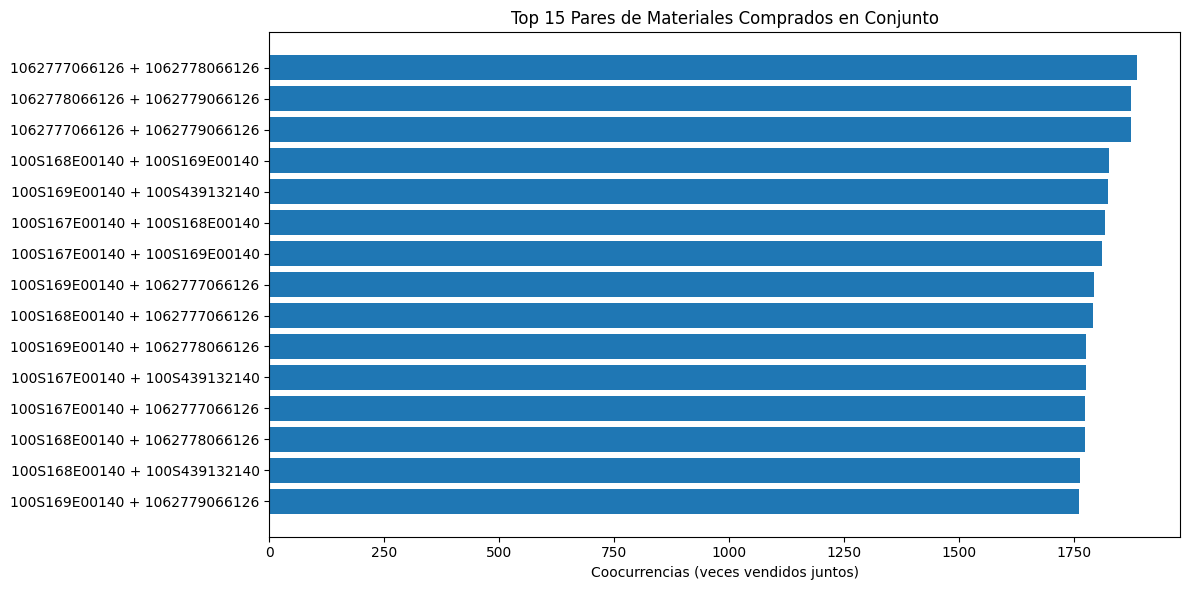

In [31]:
top_n = 15  # Número de pares a mostrar
df_pairs = cross_sell.sort_values("coocurrencias", ascending=False).head(top_n)

plt.figure(figsize=(12,6))
plt.barh(df_pairs["mat_a"].astype(str) + " + " + df_pairs["mat_b"].astype(str), df_pairs["coocurrencias"])
plt.xlabel("Coocurrencias (veces vendidos juntos)")
plt.title(f"Top {top_n} Pares de Materiales Comprados en Conjunto")
plt.gca().invert_yaxis()  # Mostrar mayor arriba
plt.tight_layout()
plt.show()

## 13) Comparativo To Market vs In Market

Objetivo: Evaluar performance por canal y definir tácticas específicas.

In [66]:
# KPIs y evolucion por canal
canal_kpis = ventas.groupby("type", as_index=False).agg(
    valor_total=("valores","sum"),
    unidades_total=("unidades","sum")
)
evo_canal = ventas.groupby([ventas["periodo"].dt.to_period("M"), "type"], as_index=False)["valores"].sum().rename(columns={"periodo":"mes"})
evo_canal["variacion_vs_mes_ant"] = evo_canal.groupby("type")["valores"].pct_change()
canal_kpis

C:\Users\gabri\AppData\Local\Temp\ipykernel_13392\2109109755.py:6: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  evo_canal = ventas.groupby([ventas["periodo"].dt.to_period("M"), "type"], as_index=False)["valores"].sum().rename(columns={"periodo":"mes"})


,type,valor_total,unidades_total
0,In Market,6.858037e+09,8.701716e+07
1,To Market,2.444823e+10,4.339955e+08


In [67]:
evo_canal

,type,valores,variacion_vs_mes_ant
0,To Market,2.384612e+08,NaN
1,To Market,2.429077e+08,0.018646
2,To Market,2.266894e+08,-0.066767
3,To Market,2.540531e+08,0.120710
4,To Market,2.608678e+08,0.026824
...,...,...,...
93,To Market,3.903496e+08,0.175328
94,In Market,3.649435e+08,0.003010
95,To Market,4.142184e+08,0.061147
96,In Market,3.568245e+08,-0.022247


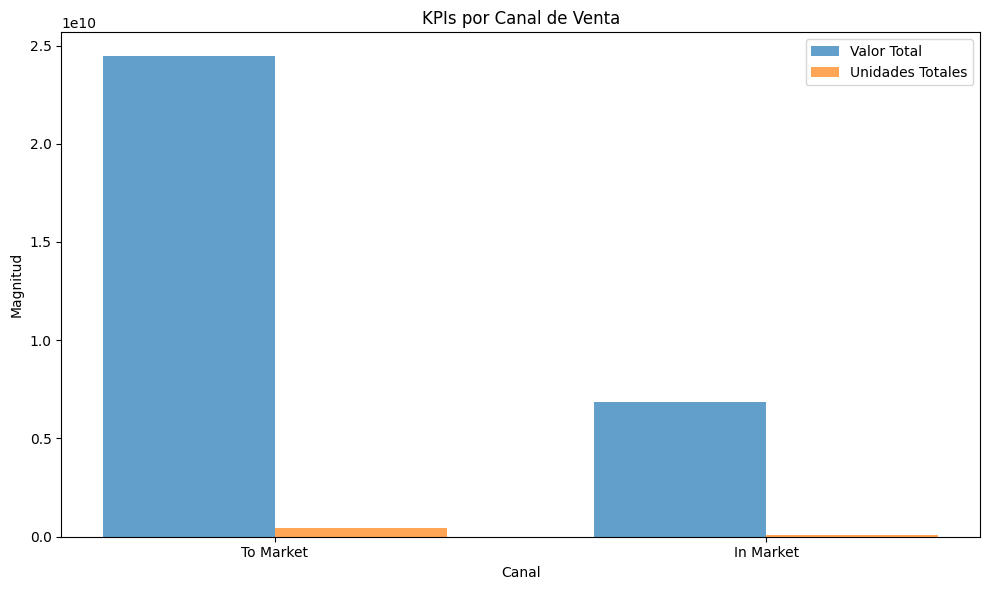

In [68]:
# Ordenamos por valor_total
df_kpi = canal_kpis.sort_values("valor_total", ascending=False)

x = np.arange(len(df_kpi["type"]))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, df_kpi["valor_total"], width, label="Valor Total", alpha=0.7)
plt.bar(x + width/2, df_kpi["unidades_total"], width, label="Unidades Totales", alpha=0.7)

plt.xticks(x, df_kpi["type"])
plt.title("KPIs por Canal de Venta")
plt.xlabel("Canal")
plt.ylabel("Magnitud")
plt.legend()
plt.tight_layout()
plt.show()


## 14) Price–Mix–Volume (PMV) básico

Objetivo: Descomponer variación de ventas en precio, mix y volumen (heurística aproximada).

In [34]:
# PMV simplificado
pmv = (ventas.assign(mes=ventas["periodo"].dt.to_period("M"))
         .groupby(["mes","id_material"], as_index=False)
         .agg(valor=("valores","sum"), unid=("unidades","sum")))
pmv["precio_prom"] = pmv["valor"] / pmv["unid"].replace(0, np.nan)
pmv_total = pmv.groupby("mes", as_index=False).agg(valor=("valor","sum"), unid=("unid","sum"))
pmv_total["precio_prom"] = pmv_total["valor"] / pmv_total["unid"].replace(0, np.nan)
pmv_total["delta_valor"]  = pmv_total["valor"].diff()
pmv_total["delta_unid"]   = pmv_total["unid"].diff()
pmv_total["delta_precio"] = pmv_total["precio_prom"].diff()
pmv_total["valor_prev"]   = pmv_total["valor"].shift(1)
pmv_total["unid_prev"]    = pmv_total["unid"].shift(1)
pmv_total["precio_prev"]  = pmv_total["precio_prom"].shift(1)
pmv_total["aporte_volumen"] = pmv_total["precio_prev"] * pmv_total["delta_unid"]
pmv_total["aporte_precio"]  = pmv_total["unid_prev"]   * pmv_total["delta_precio"]
pmv_total["aporte_mix"]     = pmv_total["delta_valor"] - (pmv_total["aporte_volumen"] + pmv_total["aporte_precio"])
pmv_total.head()

,mes,valor,unid,precio_prom,delta_valor,delta_unid,delta_precio,valor_prev,unid_prev,precio_prev,aporte_volumen,aporte_precio,aporte_mix
0,2019-01,2.384612e+08,5.554251e+06,42.933103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02,2.429077e+08,5.907291e+06,41.119980,4.446458e+06,353040.000012,-1.813123,2.384612e+08,5.554251e+06,42.933103,1.515710e+07,-1.007054e+07,-6.401049e+05
2,2019-03,2.266894e+08,6.185429e+06,36.648932,-1.621832e+07,278138.000425,-4.471048,2.429077e+08,5.907291e+06,41.119980,1.143703e+07,-2.641178e+07,-1.243568e+06
3,2019-04,2.540531e+08,6.562440e+06,38.713211,2.736376e+07,377010.999511,2.064279,2.266894e+08,6.185429e+06,36.648932,1.381705e+07,1.276845e+07,7.782559e+05
4,2019-05,2.608678e+08,7.388487e+06,35.307330,6.814625e+06,826047.000067,-3.405881,2.540531e+08,6.562440e+06,38.713211,3.197893e+07,-2.235089e+07,-2.813418e+06


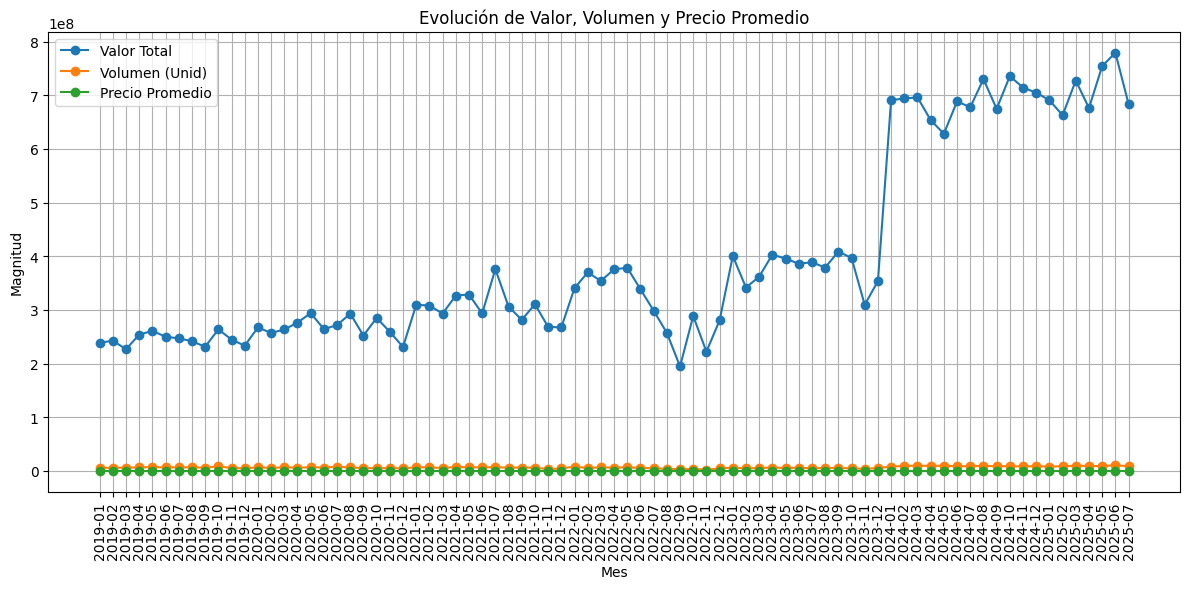

In [35]:
plt.figure(figsize=(12,6))
plt.plot(pmv_total["mes"].astype(str), pmv_total["valor"], label="Valor Total", marker='o')
plt.plot(pmv_total["mes"].astype(str), pmv_total["unid"], label="Volumen (Unid)", marker='o')
plt.plot(pmv_total["mes"].astype(str), pmv_total["precio_prom"], label="Precio Promedio", marker='o')

plt.title("Evolución de Valor, Volumen y Precio Promedio")
plt.xlabel("Mes")
plt.ylabel("Magnitud")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


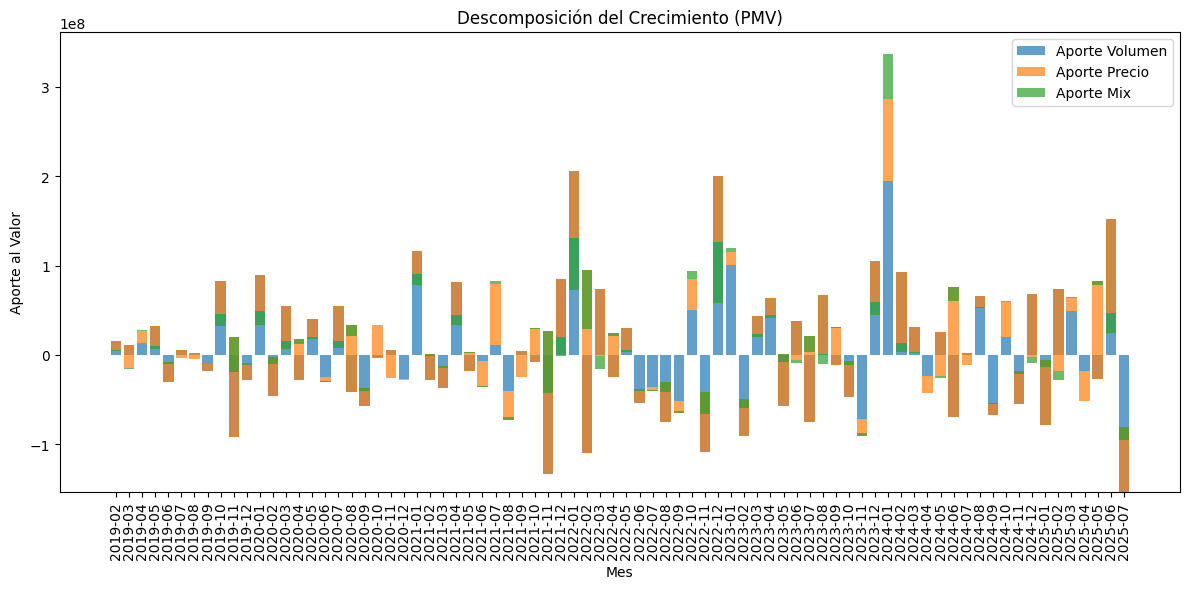

In [36]:
df_pmvd = pmv_total.dropna(subset=["aporte_volumen", "aporte_precio", "aporte_mix"])

plt.figure(figsize=(12,6))
plt.bar(df_pmvd["mes"].astype(str), df_pmvd["aporte_volumen"], label="Aporte Volumen", alpha=0.7)
plt.bar(df_pmvd["mes"].astype(str), df_pmvd["aporte_precio"], bottom=df_pmvd["aporte_volumen"], label="Aporte Precio", alpha=0.7)
plt.bar(df_pmvd["mes"].astype(str), df_pmvd["aporte_mix"], 
        bottom=df_pmvd["aporte_volumen"] + df_pmvd["aporte_precio"], 
        label="Aporte Mix", alpha=0.7)

plt.title("Descomposición del Crecimiento (PMV)")
plt.xlabel("Mes")
plt.ylabel("Aporte al Valor")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
